In [11]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
import pickle

In [12]:
with open('pred_returns.pickle', 'rb') as f:
    top20zipcode_df = pickle.load(f)

In [13]:
zipcode_list = list(top20zipcode_df['zipcode'])

In [14]:
%run ./updated_zillow_data.ipynb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15752 entries, 0 to 15751
Columns: 287 entries, RegionID to 2019-07
dtypes: float64(231), int64(52), object(4)
memory usage: 34.5+ MB


In [15]:
with open('train.pickle', 'rb') as f:
    train_df = pickle.load(f)

In [16]:
train_df.head()

,RegionName,City,State,Metro,CountyName,RegionID,SizeRank,time,value
0,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,84654,1,2012-01-01,739600.0
1,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,91982,2,2012-01-01,248800.0
2,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,84616,3,2012-01-01,931300.0
3,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,91940,4,2012-01-01,116000.0
4,79936,El Paso,TX,El Paso,El Paso County,93144,5,2012-01-01,112400.0


In [20]:
unique = list((train_df['RegionName'].unique()))

In [21]:
intersection = list(set(zipcode_list).intersection(unique))

In [22]:
intersection

[32905,
 33805,
 34207,
 33313,
 33830,
 33064,
 33705,
 33069,
 33713,
 66102,
 89030,
 30032,
 30288,
 37210,
 29405,
 32744,
 48237,
 32117,
 33020,
 33023]

In [33]:
def retrieving_zipcode_info(df, intersection):
    
    top20zipcode = {}
    
    for zipcode in intersection:
        returns = df.loc[(df['RegionName'] == zipcode)][['time', 'value']]
        returns = returns.set_index('time')

        top20zipcode[zipcode] = returns

    return top20zipcode

In [50]:
top20zipcode_dicts= retrieving_zipcode_info(train_df, intersection)

In [51]:
top20zipcode_dicts[32905]

,value
time,
2012-01-01,55000.0
2012-02-01,55300.0
2012-03-01,55900.0
2012-04-01,56600.0
2012-05-01,56600.0
2012-06-01,56400.0
2012-07-01,56500.0
2012-08-01,57400.0
2012-09-01,58700.0


In [39]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [52]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(top20zipcode_dicts[32905],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =1978.2748644261294
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =1648.765680734922
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1449.971212037261
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1194.11415125044
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1340.9000603375816
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1305.6472151626906
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1117.580086105667
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1495.8298608653727
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =1900.9854343829209
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =1593.0933188275653
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =1389.202424095513
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =1118.9906186390508
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =1635.6372849542481
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =1588.1558472895108
ARIMA (0, 0,

In [53]:
ans

[[(0, 0, 0), (0, 0, 0, 12), 1978.2748644261294],
 [(0, 0, 0), (0, 0, 1, 12), 1648.765680734922],
 [(0, 0, 0), (0, 1, 0, 12), 1449.971212037261],
 [(0, 0, 0), (0, 1, 1, 12), 1194.11415125044],
 [(0, 0, 0), (1, 0, 0, 12), 1340.9000603375816],
 [(0, 0, 0), (1, 0, 1, 12), 1305.6472151626906],
 [(0, 0, 0), (1, 1, 0, 12), 1117.580086105667],
 [(0, 0, 0), (1, 1, 1, 12), 1495.8298608653727],
 [(0, 0, 1), (0, 0, 0, 12), 1900.9854343829209],
 [(0, 0, 1), (0, 0, 1, 12), 1593.0933188275653],
 [(0, 0, 1), (0, 1, 0, 12), 1389.202424095513],
 [(0, 0, 1), (0, 1, 1, 12), 1118.9906186390508],
 [(0, 0, 1), (1, 0, 0, 12), 1635.6372849542481],
 [(0, 0, 1), (1, 0, 1, 12), 1588.1558472895108],
 [(0, 0, 1), (1, 1, 0, 12), 1162.7118555373256],
 [(0, 0, 1), (1, 1, 1, 12), 1469.817436790121],
 [(0, 1, 0), (0, 0, 0, 12), 1323.9875457288017],
 [(0, 1, 0), (0, 0, 1, 12), 1092.6798391202644],
 [(0, 1, 0), (0, 1, 0, 12), 1071.0639926012593],
 [(0, 1, 0), (0, 1, 1, 12), 871.7794825538285],
 [(0, 1, 0), (1, 0, 0, 12), 

In [54]:
# Find the parameters with minimal AIC value.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

# pdq         (1, 1, 1)
# pdqs    (1, 1, 1, 12)
# aic            277.78
# Name: 59, dtype: object

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           779.972
Name: 63, dtype: object

In [55]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(top20zipcode_dicts[32905],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7294      0.094      7.782      0.000       0.546       0.913
ma.L1          0.6629      0.109      6.065      0.000       0.449       0.877
ar.S.L12       0.0308      0.031      1.001      0.317      -0.029       0.091
ma.S.L12      -0.8293      0.273     -3.041      0.002      -1.364      -0.295
sigma2      1.586e+05   5.52e+04      2.874      0.004    5.05e+04    2.67e+05


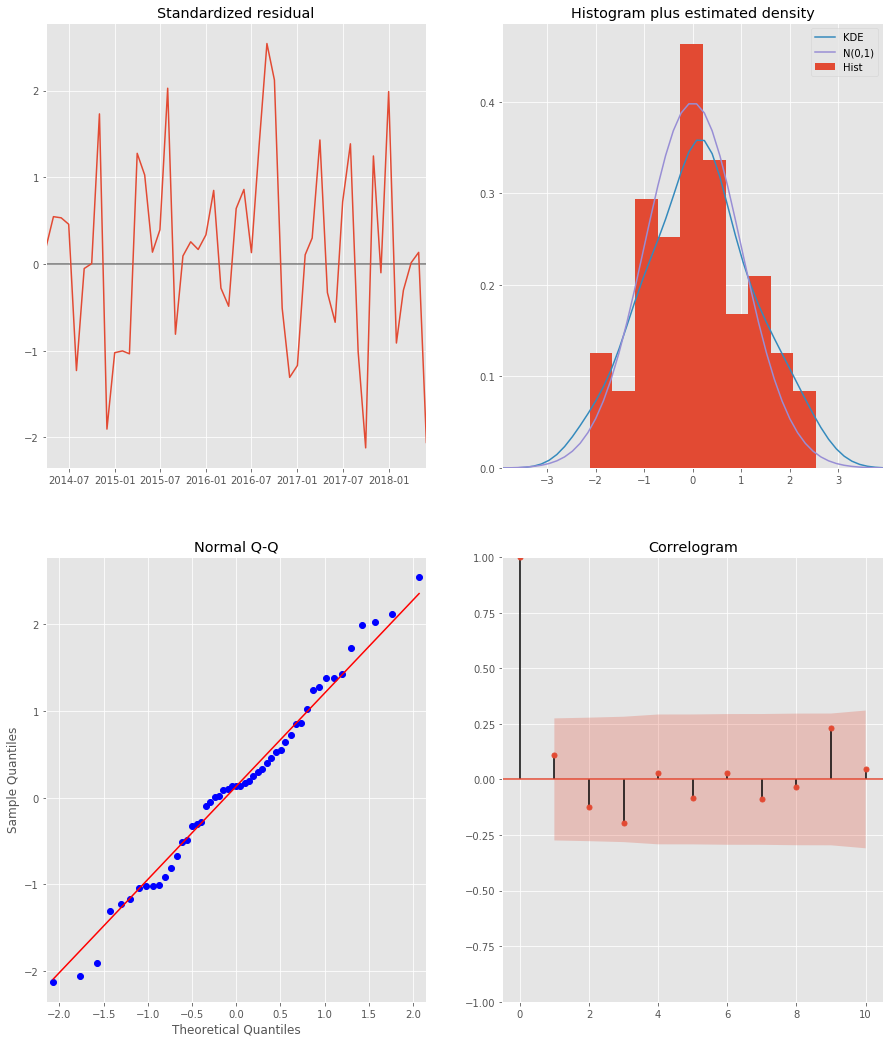

In [56]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [60]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

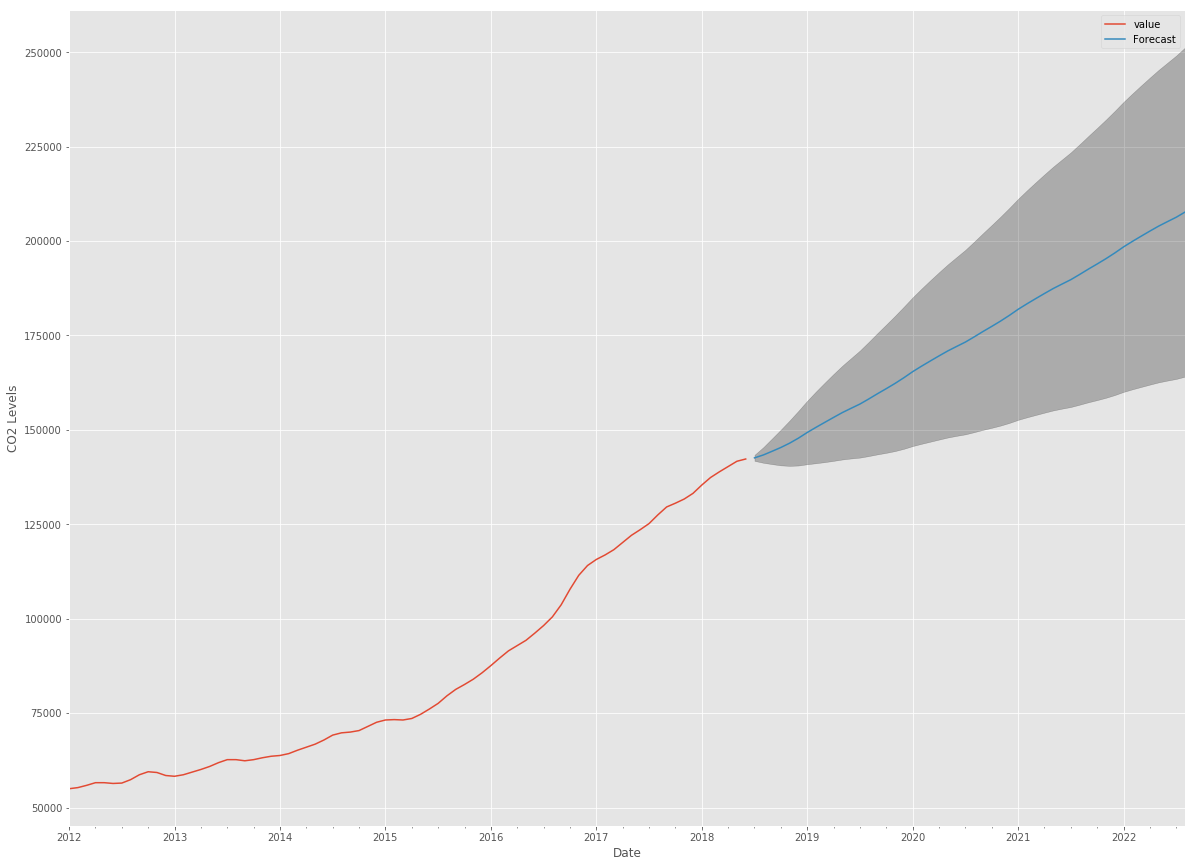

In [61]:
ax = top20zipcode_dicts[32905].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [62]:
top20zipcode_dicts

{32905:                value
 time                
 2012-01-01   55000.0
 2012-02-01   55300.0
 2012-03-01   55900.0
 2012-04-01   56600.0
 2012-05-01   56600.0
 2012-06-01   56400.0
 2012-07-01   56500.0
 2012-08-01   57400.0
 2012-09-01   58700.0
 2012-10-01   59500.0
 2012-11-01   59300.0
 2012-12-01   58500.0
 2013-01-01   58300.0
 2013-02-01   58700.0
 2013-03-01   59400.0
 2013-04-01   60100.0
 2013-05-01   60900.0
 2013-06-01   61900.0
 2013-07-01   62700.0
 2013-08-01   62700.0
 2013-09-01   62400.0
 2013-10-01   62700.0
 2013-11-01   63200.0
 2013-12-01   63600.0
 2014-01-01   63800.0
 2014-02-01   64300.0
 2014-03-01   65200.0
 2014-04-01   66000.0
 2014-05-01   66800.0
 2014-06-01   67900.0
 ...              ...
 2016-01-01   87600.0
 2016-02-01   89600.0
 2016-03-01   91500.0
 2016-04-01   92900.0
 2016-05-01   94300.0
 2016-06-01   96200.0
 2016-07-01   98200.0
 2016-08-01  100500.0
 2016-09-01  103700.0
 2016-10-01  107800.0
 2016-11-01  111500.0
 2016-12-01  114100.0
 20

In [66]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
def model_SARIMA_zipcode(df, pdq,pdqs):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])

            except:
                continue
                
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
#     ans_df.loc[ans_df['aic'].idxmin()]
    
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df,
                                order=ans_df.loc[ans_df['aic'].idxmin()]['pdq'],
                                seasonal_order=ans_df.loc[ans_df['aic'].idxmin()]['pdqs'],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    output = ARIMA_MODEL.fit()
    # Get forecast 60 steps ahead in future
    prediction = output.get_forecast(steps=60)

    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()
    return prediction

In [67]:
pred_20zipcodes={}
for zipcode in top20zipcode_dicts.keys():
    pred_20zipcodes[zipcode]= model_SARIMA_zipcode(top20zipcode_dicts[zipcode],pdq,pdqs)

In [79]:
pred_20zipcodes[32905].predicted_mean.head()

2018-07-01    142599.599273
2018-08-01    143361.780667
2018-09-01    144338.800667
2018-10-01    145347.948850
2018-11-01    146495.036696
Freq: MS, dtype: float64

In [92]:
pred_20zipcodes[32905].conf_int()

,lower value,upper value
2018-07-01,141805.477308,143393.721238
2018-08-01,141303.521366,145420.039968
2018-09-01,140940.528238,147737.073097
2018-10-01,140617.233177,150078.664523
2018-11-01,140477.346270,152512.727122
2018-12-01,140576.166128,155062.813435
2019-01-01,140913.020253,157718.553501
2019-02-01,141186.824918,160179.807866
2019-03-01,141473.465049,162528.272855
2019-04-01,141810.684922,164810.208507


In [88]:
len(pred_20zipcodes[32905].conf_int())

60

In [90]:
pred_20zipcodes[32905].conf_int().index

DatetimeIndex(['2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
      

In [115]:
np.array(pred_20zipcodes[i].predicted_mean)

array([255484.78182492, 258286.9459588 , 261237.5804954 , 264263.24999709,
       267104.55603252, 269816.4997022 , 273335.66616661, 276747.10508147,
       280102.75527332, 283457.52166832, 286920.94158184, 289836.29171882,
       292857.67611589, 295684.30698393, 298652.00008942, 301691.1736704 ,
       304571.48030656, 307340.30357119, 310863.19154597, 314243.71456264,
       317568.6955082 , 320903.1700645 , 324339.08704532, 327247.52903004,
       330274.75835332, 333105.72392932, 336076.69523024, 339118.45597296,
       342002.55930259, 344775.99522141, 348299.97035728, 351679.25191693,
       355002.86363903, 358336.49950662, 361771.04196079, 364679.31602731,
       367707.1127923 , 370538.50871763, 373509.81061482, 376551.83211787,
       379436.24990604, 382210.03409496, 385734.12575063, 389113.36907177,
       392436.92642941, 395770.53435233, 399205.01055049, 402113.28913967,
       405141.13284566, 407972.56471999, 410943.89441736, 413985.93784283,
       416870.37966149, 4

In [118]:
merged = pd.DataFrame(data=None)
for i in pred_20zipcodes.keys():
    df=pd.DataFrame()
    df['date']= pred_20zipcodes[i].conf_int().index
    df['zipcode'] = i
    df['pred_mean'] = np.array(pred_20zipcodes[i].predicted_mean)
    df['lower_value']=np.array(pred_20zipcodes[i].conf_int()['lower value'])
    df['upper_value']=np.array(pred_20zipcodes[i].conf_int()['upper value'])
    merged = pd.concat([merged, df], axis=0)

In [119]:
merged

,date,zipcode,pred_mean,lower_value,upper_value
0,2018-07-01,32905,142599.599273,141805.477308,143393.721238
1,2018-08-01,32905,143361.780667,141303.521366,145420.039968
2,2018-09-01,32905,144338.800667,140940.528238,147737.073097
3,2018-10-01,32905,145347.948850,140617.233177,150078.664523
4,2018-11-01,32905,146495.036696,140477.346270,152512.727122
5,2018-12-01,32905,147819.489781,140576.166128,155062.813435
6,2019-01-01,32905,149315.786877,140913.020253,157718.553501
7,2019-02-01,32905,150683.316392,141186.824918,160179.807866
8,2019-03-01,32905,152000.868952,141473.465049,162528.272855
9,2019-04-01,32905,153310.446715,141810.684922,164810.208507


In [143]:
from datetime import datetime

years = range(2018, 2023)
year_month_list = [datetime.strptime(f'{year}-07-01', '%Y-%m-%d').date() for year in years]
forecast_returns = merged.loc[merged['date'].isin(year_month_list)]

In [144]:
forecast_returns['pred_returns'] = forecast_returns['pred_mean'].div(
    forecast_returns.groupby('zipcode')['pred_mean'].shift(1))

In [145]:
forecast_returns = forecast_returns.dropna(subset=['pred_returns'])

In [146]:
def predicted_annualised_returns(df):
    pred_annualised_return = {}
    for zipcode in df['zipcode']:
        returns = list(df.loc[(df['zipcode'] == zipcode)]['pred_returns'])
        
        tot_return = 1
        for r in returns:
            tot_return = tot_return * r 
        
        pred_annualised = (tot_return ** (1/len(returns))) - 1
        pred_annualised_return[zipcode] = pred_annualised 
        
    return pred_annualised_return

In [147]:
forecast_returns = predicted_annualised_returns(forecast_returns)

In [148]:
forecast_returns_df = pd.DataFrame(list(forecast_returns.items()),
                                      columns=['zipcode', 'Pred_ann_returns'])

In [149]:
forecast_returns_df

,zipcode,Pred_ann_returns
0,32905,0.096734
1,33805,0.141429
2,34207,0.064434
3,33313,0.117741
4,33830,0.121049
5,33064,0.105848
6,33705,0.121680
7,33069,0.134203
8,33713,0.100178
9,66102,0.154313


In [151]:
forcast_returns_sorted = forecast_returns_df.sort_values('Pred_ann_returns', ascending=False)

In [152]:
print(f"top 5 zipcodes with Pred_ann_returns are {forcast_returns_sorted['Pred_ann_returns'][:5]}")

top 5 zipcodes with Pred_ann_returns are 14    0.213978
11    0.194591
12    0.183160
9     0.154313
10    0.153080
Name: Pred_ann_returns, dtype: float64


In [153]:
with open('forcast_returns_sorted.pickle', 'wb') as f:
    pickle.dump(forcast_returns_sorted, f, pickle.HIGHEST_PROTOCOL)

In [154]:
with open('pred_20zipcodes.pickle', 'wb') as f:
    pickle.dump(pred_20zipcodes, f, pickle.HIGHEST_PROTOCOL)